In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package('spark-nlp')
sc.install_pypi_package("torch")
sc.install_pypi_package("transformers==4.2")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1684890915056_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import *

In [ ]:
data = spark.read.json('s3://amazon-reviews-ml/json/train/dataset_zh_train.json')

# Q2

In [76]:
from transformers import pipeline
# model_name = 'uer/roberta-base-finetuned-jd-binary-chinese'
# model_name = 'uer/roberta-base-finetuned-dianping-chinese'
Models = [
    'uer/roberta-base-finetuned-jd-binary-chinese',
    'uer/roberta-base-finetuned-dianping-chinese',
    'philschmid/distilbert-base-multilingual-cased-sentiment',
    'philschmid/distilbert-base-multilingual-cased-sentiment-2',
]
# nlp = pipeline('sentiment-analysis', model=model_name)
nlps = [pipeline('sentiment-analysis', model=model_name) for model_name in models]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Downloading: 100%|##########| 814/814 [00:00<00:00, 3.95MB/s]
Downloading: 100%|##########| 541M/541M [00:08<00:00, 60.6MB/s]
Downloading: 100%|##########| 996k/996k [00:00<00:00, 55.4MB/s]
Downloading: 100%|##########| 1.96M/1.96M [00:00<00:00, 58.3MB/s]
Downloading: 100%|##########| 345/345 [00:00<00:00, 2.92MB/s]
Downloading: 100%|##########| 996k/996k [00:00<00:00, 57.6MB/s]
Downloading: 100%|##########| 1.96M/1.96M [00:00<00:00, 51.9MB/s]
Downloading: 100%|##########| 345/345 [00:00<00:00, 2.77MB/s]

In [93]:
def get_positive_sentiment_score(text, nlps):
    results = [nlp(text) for nlp in nlps]
    scores = []
    for result in results:
        try:
            scores.append(i['score'] for i in result if i['label'] == 'positive')
            scores.append(i['score'] for i in result if i['label'] == 'neutral')
            scores.append(i['score'] for i in result if i['label'] == 'positive (stars 4 and 5)')
            print(result[0])
        except:
            pass
#         positive_sentiment = result[0]['score'] if result[0]['label'] != 'negative (stars 1, 2 and 3)' else 1 - result[0]['score']
    return scores

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [94]:
text = '''
封面其实我是很喜欢的，但我觉得这个出版社是个极品，一本书，感觉像是拼凑的一样，一页里，一版加粗，一版不加！这种心情真是很随意哈！ 叔本华其实挺有趣的，很遗憾的是找不到太多的他的书！第一次了解他是亚龙的《叔本华的治疗》那种感觉，就像感觉到另一个有点郁闷的自己，随后有本传记引用的《早期手稿》，想看他的第一手材料，而不是通过另一个人看见他，所幸他确实有本经典传世作品《作为意志和表象的世界》，但我感觉这是他的论述，相当于论文一样的文章，比较想看他私人的东西，说实话，哲学对我这个学渣又没有打基础的人来说，非常，不是一般的吃力。
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
get_positive_sentiment_score(text, nlps)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'label': 'negative (stars 1, 2 and 3)', 'score': 0.7045357823371887}
{'label': 'negative (stars 1, 2 and 3)', 'score': 0.8519057035446167}
{'label': 'negative', 'score': 0.6651836037635803}
{'label': 'neutral', 'score': 0.524416983127594}
[<generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe6f9879ed0>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70ea8a950>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c250>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c3d0>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c150>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c450>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c4d0>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x7fe70591c5d0>, <generator object get_positive_sentiment_score.<locals>.<genexpr> at 0x

In [57]:
data[data['stars'] == 5].head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(language='zh', product_category='shoes', product_id='product_zh_0119888', review_body='还不错，黑五价格很优惠，和预想的差不多。本人运动鞋穿40的，买的7，鞋有点长，大小差不多，仅供参考。', review_id='zh_0077209', review_title='很满意。', reviewer_id='reviewer_zh_0477454', stars='5'), Row(language='zh', product_category='book', product_id='product_zh_0886806', review_body='非常实用，已开始编织小杯垫，彩页是基础花样，后面有大型的图案～', review_id='zh_0680449', review_title='实用，花样很多。', reviewer_id='reviewer_zh_0813215', stars='5'), Row(language='zh', product_category='watch', product_id='product_zh_0854937', review_body='除了物流慢，其他完美，减了200元，包装完好。', review_id='zh_0021933', review_title='不错，表带没想象中硬', reviewer_id='reviewer_zh_0538486', stars='5'), Row(language='zh', product_category='book', product_id='product_zh_0345287', review_body='东野叔的书，白夜行的姐妹篇，盛名之下去买的看的，只能说东野不会让人失望', review_id='zh_0159792', review_title='幻夜', reviewer_id='reviewer_zh_0408869', stars='5'), Row(language='zh', product_category='beauty', product_id='product_zh_0143288', review_body='给孩子买的，镇静作用还好。不过主要还

In [72]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("philschmid/distilbert-base-multilingual-cased-sentiment-2", num_labels=3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from transformers import AutoTokenizer

In [96]:
tokenizer = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")
model = AutoModelForSequenceClassification.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")
tokenizers = [AutoTokenizer.from_pretrained(model_name) for model_name in Models]
models = [AutoModelForSequenceClassification.from_pretrained(model_name) for model_name in Models]

def get_score(text):
    sentiment_scores = []
    for i in range(len(Models)):
        tokenizer = tokenizer[i]
        model = models[i]
        encoded_input = tokenizer(text, return_tensors='pt')
        with torch.no_grad():
            logits = model(**encoded_input).logits
            probabilities = torch.softmax(logits, dim=1).squeeze()
            sentiment_scores.extprobabilities.tolist()
    
print(sentiment_scores)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'AutoTokenizer' is not defined
Traceback (most recent call last):
NameError: name 'AutoTokenizer' is not defined



In [5]:
data = data.withColumn('good_review', (data.star_rating >= 4).cast("integer")) \
                           .persist()
data = data.withColumn('title_len', (length(data.product_title)).cast("integer")) \
                           .persist()
data = data.withColumn('helpful_prop', (data.helpful_votes / data.total_votes).cast("double")) \
                           .persist()
data = data.withColumn('verified_pur', (data.verified_purchase == "Y").cast("integer")) \
                           .persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sampled = data.sampleBy("good_review", fractions={1:0.2,0:1},seed = 521)
sampled.groupBy('good_review').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+
|good_review|  count|
+-----------+-------+
|          1|3443123|
|          0|3517710|
+-----------+-------+

# Q3

In [7]:
features = ['total_votes', "title_len", "helpful_prop", "verified_pur"]
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
try:
    sampled = sampled.drop("features")
except:
    pass
sampled = assembler.transform(sampled.na.drop())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
def Train(model, train):
    if train is not None:
        model = model.fit(train)
        trainingSummary = model.summary
        print("Training AUC: " + str(trainingSummary.areaUnderROC))
        print("\nFalse positive rate by label (Training):")
        for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
            print("label %d: %s" % (i, rate))
        print("\nTrue positive rate by label (Training):")
        for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
            print("label %d: %s" % (i, rate))
        print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
    return model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
train, test = sampled.randomSplit([0.7, 0.3], seed = 521)
lr = LogisticRegression(featuresCol='features', labelCol='good_review')
trained1 = Train(lr, train)
evaluationSummary1 = trained1.evaluate(test)
print("Test AUC: ", str(evaluationSummary1.areaUnderROC))
print("Test Accuracy: ", str(evaluationSummary1.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6912568033607035

False positive rate by label (Training):
label 0: 0.4726280792931711
label 1: 0.23405795555414424

True positive rate by label (Training):
label 0: 0.7659420444458558
label 1: 0.5273719207068289

Training Accuracy: 0.6667222146548152
Test AUC:  0.6918882811917045
Test Accuracy:  0.6672860065693302

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

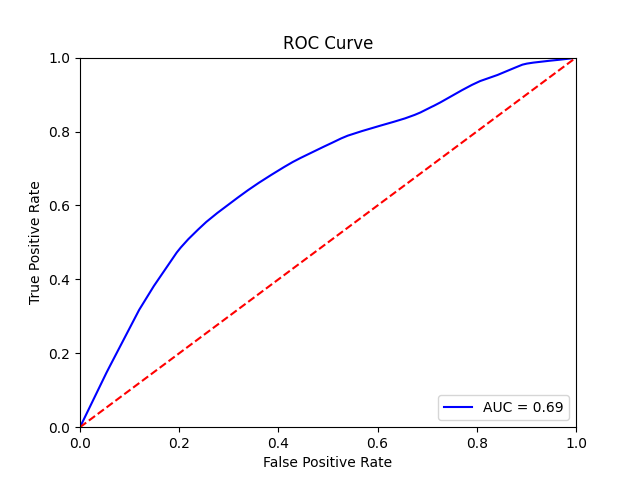

In [23]:
roc_df = evaluationSummary1.roc.toPandas()
plt.close()
plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary1.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
%matplot plt

# Q4

In [14]:
train_data = train.withColumnRenamed("good_review","label")
test_data = test.withColumnRenamed("good_review","label")
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.regParam, np.arange(0,.1,.01)) \
.addGrid(lr.elasticNetParam, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=320, numFolds = 5)
cvModel = cv.fit(train_data)
print(cvModel.bestModel.getRegParam())
print(cvModel.bestModel.getElasticNetParam())
best = cvModel.bestModel
evaluationSummary2 = best.evaluate(test_data)
print("Test AUC: ", str(evaluationSummary2.areaUnderROC))  
print("Test Accuracy: ", str(evaluationSummary2.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.0
1.0
Test AUC:  0.6918443754172726
Test Accuracy:  0.6672860065693302

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

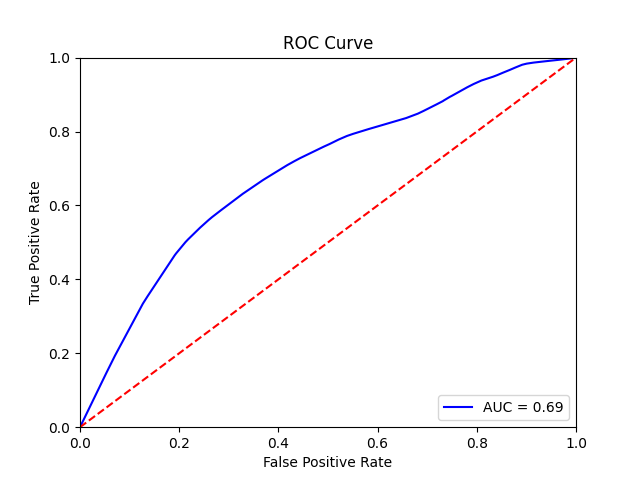

In [15]:
roc_df = evaluationSummary2.roc.toPandas()
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary2.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

In [16]:
print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(evaluationSummary2.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(evaluationSummary2.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


False positive rate by label (Training):
label 0: 0.4714433841175984
label 1: 0.23361619608520423

True positive rate by label (Training):
label 0: 0.7663838039147958
label 1: 0.5285566158824017